# **Time evolution of quantum many-body systems using MPS**

**By: JOAQUIN G. MARQUEZ OLGUIN**

Master in Quantum Science and Technology

## **Introduction and Physical System**

The aim of this assignment is to simulate the dynamics of a quantum many-body system after applying a simple quantum quench. In particular, we study the real-time evolution of the Transverse-Field Ising Model (TFIM) on a 1D spin chain with open boundary conditions.

The system is governed by the following Hamiltonian:
$$
\begin{equation*}
    H_{Ising}(g) = \sum_{i=1}^{N-1} X_{i}X_{i+1} + g\sum_{i=1}^{N} Z_{i},
\end{equation*}
$$
where $X_i$ and $Z_i$ denote the Pauli matrices $\sigma_x$ and $\sigma_z$ acting on site $i$.

Regarding the quench protocol, we initialize the system in the following product state:
$$
\begin{equation*}
|\psi_{0}\rangle = \bigotimes_{i=1}^{N} |\uparrow\rangle_{i},
\end{equation*}
$$
At time $t=0$, we quench the system by evolving it with the Hamiltonian $H_{Ising}(g)$ where $g=0.7$. We are interested in computing the expectation value of the local operator $Z$ at the center of the chain:
$$
\begin{equation*}
\langle Z_{N/2}(t) \rangle = \langle \psi(t) | Z_{N/2} | \psi(t) \rangle,
\end{equation*}
$$
where $|\psi(t)\rangle = e^{-iHt} |\psi_0\rangle$.

---

## **The MPS Class**

Before moving to the time evolution of the quantum quench, I present the MPS class (that I implemented during my internship at ICFO) which encapsulates the state representation and the linear algebra operations that we will use to run the simulation.

The functions that we will primarily use for the time evolution algorithm (of part I) will be: 
- ```expectation_value```: Instead of directly contracting the full network (which could be pretty costly), this function implements what is known as a "zipper" contraction. It iterates through the chain, contracting the environment tensor with the MPS tensors site-by-site. When it reaches the target site_idx, it applies the local operator and then continues the contraction.

- ```apply_mpo```: This method implements the action of a Matrix Product Operator (in our case, the Trotter gates) on the state. It contracts the physical legs of the MPO and MPS and fuses their bond indices. It is important to note the convention we take for the MPOs is defined here; and that this operation increases the bond dimension $\chi \to \chi \cdot \chi_{MPO}$.

- ```compress```: To prevent the bond dimension from exploding during time evolution, this method performs a right-to-left sweep using Singular Value Decomposition (SVD). At each bond, it truncates the singular values, keeping only the largest max_bond_dim values. This way, we essentially project the state back onto the manifold of MPS with tractable bond dimension (this is what the approximation in TEBD is based on).

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.linalg
import copy

class MPS:

    def __init__(self, N, d_phys, A):
        """
        initialize MPS object
        
        :param N: number of sites
        :param d_phys: physical dimension (leg)
        :param A: list of tensors: A[n].shape = (d_phys, b_dim_left, b_dim_right)
        """

        self.N, self.d_phys = N, d_phys
        self.A = [item for item in A] 

        if self.N == 50: # For Part I
            self.left_canonical_form()
            self.canonical_center = self.N-1
        else: # Part II
            self.canonical_center = None
        
    def left_canonical_form(self):
        """
        Converts the MPS into left canonical form using QR decomposition
        """

        for n in range(self.N-1):

            shape = self.A[n].shape

            # QR decomposition: Q is an orthogonal matrix, R is an upper triangular matrix
            # reshape A[n] into a matrix of shape (d_phys*b_dim_left, b_dim_right)
            q, r = np.linalg.qr(self.A[n].reshape(shape[0]*shape[1], shape[2]), mode = 'reduced')
            # shape of q is (d * b_dim_left, K)
            # shape of r is (K, b_dim_right)
            # K = b_dim_right

            self.A[n] = q.reshape(shape[0], shape[1], -1) # store Q back in A[n] in the original shape (with updated b_dim_right represented by "-1")
            self.A[n+1] = np.tensordot(self.A[n+1], r, axes = (1, 1)) # contract (right leg of) r and (left leg of) A[n+1]; axes=( [legs_of_A], [legs_of_r] )
            self.A[n+1] = np.transpose(self.A[n+1], axes = (0, 2, 1)) # shape adjustment after contraction wih tesor product

        self.canonical_center = self.N-1 # Every tensor from 0 to N-2 is a "Left Isometry" (A[n]^\dagger A[n] = I), while A[N-1] holds the normalization information of the wf

    def compute_amplitude(self, idx):
        """
        Probability amplitude coefficient for a given configuration idx (for a specific computational basis state)

        Procedure: take the tensor at site 0, slice it with idx[0] and shape (d, 1, R) -> (1, R) row vector
        then itereate for every next site n until the last tensor: (1, R) @ (D, D) @ ... @ (D, 1) -> scalar
        
        :param idx: list of integers of length N representing the state at each site
        """

        if len(idx) != self.N:
            raise ValueError("Length of idx must be equal to N")
        
        res = self.A[0][idx[0]] # shape (1, R)

        for n in range(1, self.N): # loop from site 1 to N-1
            matrix = self.A[n][idx[n]]
            
            # Matrix multiplication: (1, D) @ (D, D) -> (1, D)
            res = res @ matrix
        
        return res[0,0]


    def norm_canonical(self):
        """
        Computes normm using the canonical form of the MPS (valid only if the MPS is in right/left canonical form)
        """
        if self.canonical_center == 0:
            return np.linalg.norm(self.A[0].flatten())
        elif self.canonical_center == self.N - 1:
            return np.linalg.norm(self.A[-1].flatten())
        else:
            return self.norm_general()
    
    def norm_general(self):
        """
        Computes norm by contracting the full network from left to right for a general MPS
        """

        env = np.eye(1) # initial environment (scalar 1 represented as a 1x1 identity matrix with shape (bra_L, ket_L))

        for n in range(self.N):
            A = self.A[n]
            # both with shape: (d, L, R)

            # 1st step: contract env with ket A over the left bond
            temp = np.tensordot(env, self.A[n], axes = (1, 1)) # shape: (bra_L, d, R) after contraction

            # 2nd step: contract the result with bra A_conj over physical index and left bond
            env = np.tensordot(self.A[n].conj(), temp, axes = ([0,1], [1,0])) # shape: (R_bra, R_ket) after contraction
        return np.sqrt(np.real(env[0,0]))
    
    def expectation_value(self, op, site_idx):
        """
        Computes the expectation value <Psi|op|Psi> at a single site.
        
        :param op: Single site operator (d x d matrix)
        :param site_index: Index of the site to apply the operator
        """
        env = np.eye(1) # initial environment

        for n in range(self.N):
            tensor = self.A[n] # shape (d, L, R)
            
            if n == site_idx:
                # Contract op with physical leg of tensor
                # op is (d, d), tensor is (d, L, R) -> result (d, L, R)
                tensor = np.tensordot(op, tensor, axes=(1, 0))
            
            # Contract with the environment (same as norm_general)
            temp = np.tensordot(env, tensor, axes=(1, 1)) # (bra_L, d, R)
            env = np.tensordot(self.A[n].conj(), temp, axes=([0, 1], [1, 0])) # (R_bra, R_ket)

        return np.real(env[0, 0])

    def apply_mpo(self, mpo):
        """
        Applies an MPO to the current MPS state: |Psi'> = O |Psi>
        Returns a NEW MPS object
        
        mpo: list of Rank-4 tensors with shape: (d_out, d_in, b_dim_L_mpo, b_dim_R_mpo)
        """
        if len(mpo) != self.N:
            raise ValueError("MPO length must match MPS length")

        new_A = []

        for n in range(self.N):
            # MPS Tensor A[n]: (d_in, L, R)
            # MPO Tensor W[n]: (d_out, d_in, L_w, R_w) where convection is: group physical legs first, then bond legs
            
            # 1st connect MPO axis 1 (d_in) with MPS axis 0 (d_in)
            # result shape: (d_out, L_w, R_w, L, R)
            temp = np.tensordot(mpo[n], self.A[n], axes=([1], [0]))
            
            # 2nd transpose to group lefts and rights legs together
            # result shape: (d_out, L_w, L, R_w, R)
            temp = np.transpose(temp, (0, 1, 3, 2, 4))
            shape = temp.shape
            
            # 3rd fuse the resulting bond indices
            # New Left Bond Dim = L_w * L
            # New Right Bond Dim = R_w * R
            # final shape: (d_out, New_L, New_R)
            new_tensor = temp.reshape(shape[0], shape[1]*shape[2], shape[3]*shape[4])

            new_A.append(new_tensor)

        new_d_phys = [tensor.shape[0] for tensor in new_A]
        return MPS(self.N, new_d_phys, new_A)
    
    def compress(self, max_bond_dim):
        """
        Compresses the MPS to a maximum bond dimension using SVD.
        Sweeps Right -> Left (N-1 to 0).
        """
        # 1st start with QR decomposition (weights are at the right end)
        self.left_canonical_form() 
        
        # 2nd iterate backwards from N-1 down to 1 (site 0 doesn't need compression since we are compressing the left bonds)
        for n in range(self.N - 1, 0, -1):

            # A[n] shape: (d, L, R), and we want to compress the left bond L
            # Reshape to Matrix M: Rows=L, Cols=(d, R)    +     Transpose (d, L, R) -> (L, d, R)
            temp = np.transpose(self.A[n], (1, 0, 2))
            shape = temp.shape # (L, d, R)
            matrix = temp.reshape(shape[0], shape[1] * shape[2])
            
            # 3rd SVD decomposition: M = U * S * Vh
            U, s, Vh = np.linalg.svd(matrix, full_matrices=False)
            
            # 4th Truncate
            dim_keep = min(len(s), max_bond_dim)
            
            U_trunc = U[:, :dim_keep]        # Shape: (L, dim_keep)
            s_trunc = s[:dim_keep]           # Shape: (dim_keep)
            Vh_trunc = Vh[:dim_keep, :]      # Shape: (dim_keep, d*R)
            
            # 5th Update A[n] with Vh, and reshape back to tensor form -> (dim_keep, d, R) -> Transpose to (d, dim_keep, R)
            self.A[n] = Vh_trunc.reshape(dim_keep, shape[1], shape[2]).transpose(1, 0, 2)
            
            # 6th Push T = U_trunc * s_trunc (which has shape (L, dim_keep)) to the left neighbor A[n-1] with shape (d, L_prev, R_prev) 
            T = U_trunc * s_trunc[None, :] 
            
            # Note that here R_prev == L, so we contract over that axis
            self.A[n-1] = np.tensordot(self.A[n-1], T, axes=([2], [0]))
        
        self.canonical_center = 0 # now the center of orthogonality is at site 0
        
    def entropy_at_center(self):
        """
        Computes the Von Neumann entropy at the central bond.
        Useful for checking convergence of Transfer Matrix multiplication in Part II.
        """
        center_idx = self.N // 2
        # Contract (d, L, R) -> (d*L, R)
        A = self.A[center_idx]
        d, D_L, D_R = A.shape
        matrix = A.transpose(0, 1, 2).reshape(d * D_L, D_R)
        
        # SVD
        s = np.linalg.svd(matrix, compute_uv=False)
        
        # Calculate Entropy
        s2 = s**2
        s2 = s2[s2 > 1e-12] # Filter numerical noise
        s2 /= np.sum(s2)    # Force normalized probabilities
        
        return -np.sum(s2 * np.log(s2))
    
    def entropy_profile(self):
        """
        Computes the Von Neumann entropy across every bond of the MPS.
        Performs a Right-to-Left sweep (similar to compress) to store
        the singular values at each bond without truncating.
        """
        psi = copy.deepcopy(self)
        
        # We start in Left Canonical Form (weights at the right edge)
        psi.left_canonical_form()
        
        entropies = [0.0] * (psi.N - 1)
        
        # Sweep Right -> Left (from site N-1 down to 1)
        for n in range(psi.N - 1, 0, -1):
            # A[n] shape: (d, L, R)
            # We want to separate the Left Bond 'L' from the rest (d, R)
            # Permute to (L, d, R) and reshape to Matrix (L, d*R)
            temp = np.transpose(psi.A[n], (1, 0, 2))
            shape = temp.shape 
            matrix = temp.reshape(shape[0], shape[1] * shape[2])
            
            # SVD: M = U * s * Vh
            U, s, Vh = np.linalg.svd(matrix, full_matrices=False)
            
            # Entropy from singular values:
            s2 = s**2
            s2 = s2[s2 > 1e-12] # Filter numerical zeros
            s2 /= np.sum(s2)    # Normalize
            S = -np.sum(s2 * np.log(s2))
            entropies[n-1] = S
            
            # T = U * s  with shape (L_dim, k) where k = # of singular values (Schmidt rank from the SVD)
            T = U * s[None, :]
            
            # Contract A[n-1] (d, L_prev, R_prev) with T (R_prev, k)
            # Note: R_prev of A[n-1] is the Left Bond of A[n]
            psi.A[n-1] = np.tensordot(psi.A[n-1], T, axes=([2], [0]))
            
        return np.array(entropies)
    
    @classmethod
    def init_vertical_boundary(cls, length, d_phys=1, bond_dim=1, state_type='vacuum'):
        """
        Class method to create a vertical boundary MPS.
        
        Args:
            length: Total number of vertical sites (3 * time_steps).
            d_phys: Physical dimension (1 for vacuum/edge/boundaries, 4 for bulk).
            state_type: 'vacuum' for |00...0>, 'random' for random normalized state.
        """
        if state_type == 'vacuum':
            # Create product state |00...0>
            A_list = [np.zeros((d_phys, 1, 1)) for _ in range(length)]
            for A in A_list: 
                A[0, 0, 0] = 1.0
            return cls(length, d_phys, A_list)
            
        elif state_type == 'random':
            # Create random MPS
            A_list = []
            for _ in range(length):
                # Random tensor normalized
                A = np.random.rand(d_phys, bond_dim, bond_dim) - 0.5    # random number between -0.5 and 0.5
                A_list.append(A)
            
            mps = cls(length, d_phys, A_list)
            
            # Fix edges to dimension 1
            mps.A[0] = mps.A[0][:, 0:1, :]
            mps.A[-1] = mps.A[-1][:, :, 0:1]
            
            # Canonicalize to ensure norm = 1
            mps.left_canonical_form()
            return mps


---

## **Part I:** Expectation value using TEBD

The first approach we will take to compute the time evolution efficiently using MPS is the so called Time Evolving Block Decimation (TEBD) algorithm. In it, we make use of the Trotter-Suzuki decomposition to break the time evolution operator $U(t) = e^{-iHt}$ into small time steps $\delta t$.

Since the Hamiltonian terms $X_i X_{i+1}$ and $Z_i$ do not commute, we cannot simply exponentiate them individually. Instead, we use a second-order symmetric Trotter expansion, given by:
$$
\begin{equation*}
U(\delta t) \approx e^{-i H_{odd} \delta t / 2} e^{-i H_{even} \delta t} e^{-i H_{odd} \delta t / 2} + O(\delta t^3),
\end{equation*}
$$
where $H_{odd}$ and $H_{even}$ contain the commuting terms on odd and even bonds, respectively. This allows us to represent the time evolution operator as a sequence of local two-body gates, which we convert into MPOs. 

Finally, we apply these MPOs sequentially to the state $|\psi(t)\rangle$, always keeping in mind that after each application, the bond dimension of the MPS increases, so we need to truncate it back to a maximum value ($\chi=200$) using SVD to maintain computational efficiency.

### **Implementation Strategy**

To implement this simulation efficiently, we break the process down into three steps corresponding to the helper functions defined below:

1. Constructing the Local Gate (```build_two_site_gate```): First, we decompose the Hamiltonian into a sum of local two-body terms, $H = \sum_i h_{i,i+1}$. The interaction on a single bond is then given by: 

    $h_{i,i+1} = X_i X_{i+1} + \frac{g}{2} Z_i + \frac{g}{2} Z_{i+1}.$ 

    We exponentiate this term to obtain the local unitary gate $U_{bond} = e^{-i h_{i,i+1} \delta t}$. This results in a rank-4 tensor representing the evolution operator acting on two consecutive physical sites.

2. Decomposition into MPO Tensors (```gate_to_mpo```): We cannot apply a 2-site gate directly to an MPS without breaking its structure, so we must split it. We use SVD to decompose the rank-4 gate into two smaller tensors, $W_{left}$ and $W_{right}$. To maintain symmetry, we split the singular values evenly ($\sqrt{S}$) between the two sides. These tensors form the building blocks of our MPO, while keeping the structure of our MPO convection (defined in our MPS class).

3. Building the Trotter Layers (```build_trotter_layers```): Finally, we assemble these local blocks into global operators. We create two distinct MPO layers:
- Odd Layer: Acting on bonds $(0,1), (2,3), \dots$
- Even Layer: Acting on bonds $(1,2), (3,4), \dots$

    Following the second-order Trotter expansion, we structure the time step as a "sandwich": we apply a half-step ($\delta t/2$) of the Odd layer, followed by a full step ($\delta t$) of the Even layer, and finish with the remaining half-step of the Odd layer.


In [47]:
# HELPER FUNCTIONS

def build_two_site_gate(g, dt):
    """
    Constructs the two-site unitary operator U = exp(-i * h * dt)
    for the 2-site Hamiltonian: h = X X + (g/2) Z I + (g/2) I Z
    """
    # Pauli Matrices
    X = np.array([[0., 1.], [1., 0.]])
    Z = np.array([[1., 0.], [0., -1.]])
    I = np.eye(2)
    
    # 2-site Hamiltonian terms
    XX = np.kron(X, X)
    ZI = np.kron(Z, I)
    IZ = np.kron(I, Z)
    
    h = XX + (g/2) * ZI + (g/2) * IZ
    
    # Take the exponential to get U
    U = scipy.linalg.expm(-1j * h * dt)
    
    # Reshape into a rank-4 tensor MPO (d, d, d, d), where (d_out, d_in, L, R) is our MPO convention
    # We take bond dimension d = 2 becase the 2-site operator can be written as a sum of just 2 product terms (Schmidt rank = 2)
    return U.reshape(2, 2, 2, 2)

def gate_to_mpo(gate_tensor):
    """
    Decomposes a 2-site gate (rank-4 tensor) into two MPO tensors using SVD.
    Gate shape: (i_out, j_out, i_in, j_in)
    Returns: W_left, W_right (MPOs)
    """
    # Our MPO convection is (d_out, d_in, L, R) = (up, down, left, right). 
    # In order to do SVD, we need to reshape the tensor into a matrix by grouping left and right indices. 
    # Although the bond dimensions are the same in this case, it is good practice to keep an order:
    # we transpose the tensor from (up, down, left, right) -> (up, left, down, right) = (i_out, i_in, j_out, j_in)
    T = gate_tensor.transpose(0, 2, 1, 3) 
    shape_T = T.shape # (2, 2, 2, 2)
    matrix = T.reshape(shape_T[0]*shape_T[1], shape_T[2]*shape_T[3])    # shape = (i_out * i_in, j_out * j_in) matrix
    
    # SVD
    U, s, Vh = np.linalg.svd(matrix, full_matrices=False)
    
    # Symmetrically absorb singular values into U and Vh
    s_sqrt = np.sqrt(s)
    U = U * s_sqrt[None, :]     # shape (i_in * i_out, k)
    Vh = s_sqrt[:, None] * Vh   # shape (k, j_in * j_out)
    
    # Reshape back to MPO format:
    # W_left: (i_out, i_in, bond_L=1, bond_R=S) -> standard format (d_out, d_in, L, R)
    k = len(s)
    W_left = U.reshape(shape_T[0], shape_T[1], k, 1).transpose(0, 1, 3, 2) # we add dummy bond dim for the left and keep the right bond as k (SVD rank)
    
    # W_right: (j_out, j_in, bond_L=S, bond_R=1) -> standard format (d_out, d_in, L, R)
    W_right = Vh.reshape(k, shape_T[2], shape_T[3], 1).transpose(1, 2, 0, 3)
    
    return W_left, W_right

def get_trotter_gates(g, dt):
    """
    Generates the SVD-decomposed tensors for the Trotter steps.
    """
    # Half step (dt/2)
    gate_half = build_two_site_gate(g, dt / 2.0)
    WL_h, WR_h = gate_to_mpo(gate_half) 
    
    # Full step (dt)
    gate_full = build_two_site_gate(g, dt)
    WL_f, WR_f = gate_to_mpo(gate_full) 
    
    return WL_h, WR_h, WL_f, WR_f

def build_trotter_layers(N, g, dt):
    """
    Creates the Odd and Even MPO layers for 2nd order Trotter: U(dt) ~ U_odd(dt/2) U_even(dt) U_odd(dt/2)

    They can be visually seen as the "half-step" odd layers are the buns of a sandwich, and the "full-step" even layer is the ham in the center
    """
    # Trotter gates
    WL_half, WR_half, WL_full, WR_full = get_trotter_gates(g, dt)

    # EVEN LAYER (acting on 1-2, 3-4, ...)
    mpo_even = []

    # Note: the first site (site 0) does not do anything in an Even layer -> Identity
    # In our convention, the Identity MPO tensor has shape (2, 2, 1, 1)
    Id = np.eye(2).reshape(2, 2, 1, 1)
    mpo_even.append(Id)
    
    i = 1
    while i < N:
        if i + 1 < N:
            # Place gate on i, i+1
            mpo_even.append(WL_full)
            mpo_even.append(WR_full)
            i += 2
        else:
            # Leftover site at the boundary
            mpo_even.append(Id)
            i += 1

    # ODD LAYER (acting on 0-1, 2-3, ...)
    mpo_odd = []
    i = 0
    while i < N:
        if i + 1 < N:
            # Place gate on i, i+1
            mpo_odd.append(WL_half)
            mpo_odd.append(WR_half)
            i += 2
        else:
            # Note: the leftover site (last site) does not do anything in an Odd layer -> Identity
            mpo_odd.append(Id)
            i += 1
            
    return mpo_odd, mpo_even

Now, we run the simulation with $N=50$ spins from $T=0$ to $T=4$ (time step $\delta=0.1$). We want to obtain the time evolution of the lozal $Z$ operator acting on the central spin, keeping the bond dimension up to the maximum value $\chi=200$.

In [48]:
print("Starting TEBD Simulation...")

# SIMULATION PARAMETERS
N = 50
g = 0.7
T_final = 4.0
dt = 0.1
bond_dim_max = 200
central_site = N // 2

# Build the initial state psi_0
# We build a product state in which each tensor has shape (d=2, L=1, R=1) with d = 0 (spin up)
A_list = []
for i in range(N):
    tensor = np.zeros((2, 1, 1), dtype=float)
    tensor[0, 0, 0] = 1.0  # amplitude for spin up (corresponding to s = 0) 
    A_list.append(tensor)

psi = MPS(N, 2, A_list)

# Get the "Sandwich" layers: 
# Odd layer evolves for dt/2, Even layer evolves for full dt
mpo_odd_half, mpo_even_full = build_trotter_layers(N, g, dt)

# Pauli Z (local) operator to be measured
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])

steps = int(T_final / dt)
times = [0.0]
observables = []

# Measure the observable at t=0
z_val = psi.expectation_value(sigma_z, central_site)
observables.append(z_val)

for t in tqdm(range(1, steps + 1)):
    # Apply "The Sandwich" time step:

    # Top Bun: Odd Layer (dt/2)
    psi = psi.apply_mpo(mpo_odd_half)
    psi.compress(bond_dim_max) 
    # Meat: Even Layer (dt)
    psi = psi.apply_mpo(mpo_even_full)
    psi.compress(bond_dim_max)
    # Bottom Bun: Odd Layer (dt/2)
    psi = psi.apply_mpo(mpo_odd_half)
    psi.compress(bond_dim_max)
    
    # Normalize (to keep the state stable) and Measure the observable
    norm = psi.norm_canonical()
    psi.A[0] /= norm

    z_val = psi.expectation_value(sigma_z, central_site)
    observables.append(z_val)
    current_time = t * dt
    times.append(current_time)


Starting TEBD Simulation...


100%|██████████| 40/40 [31:07<00:00, 46.69s/it]


C:\Users\jmarq\AppData\Local\Temp\ipykernel_13548\3347316988.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


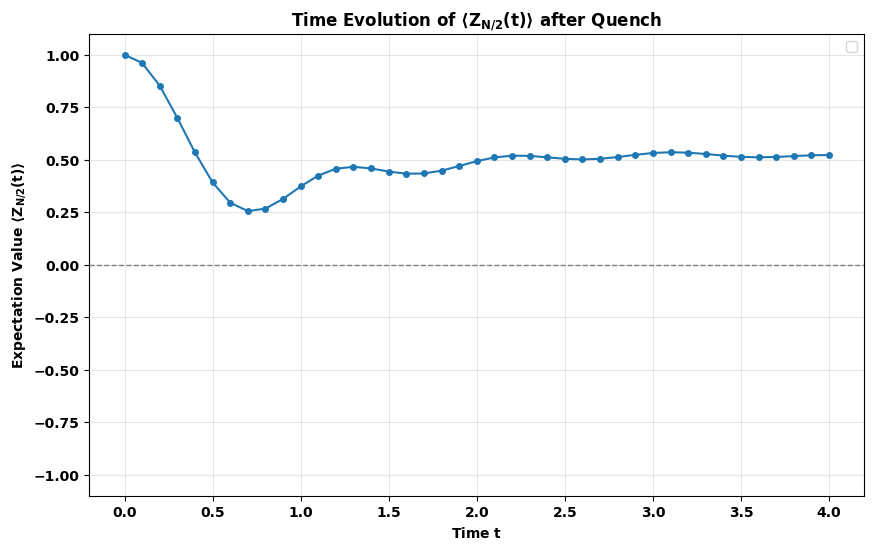

In [49]:
# PLOTTING 

plt.figure(figsize=(10, 6))
plt.plot(times, observables, 'o-', markersize=4)
plt.xlabel('Time $t$')
plt.ylabel(r'Expectation Value $\langle Z_{N/2}(t) \rangle$')
plt.title(r'Time Evolution of $\langle Z_{N/2}(t) \rangle$ after Quench')
plt.axhline(0, color='gray', ls='--', lw=1)
plt.ylim(-1.1, 1.1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

---

## **Part II:** Expectation Value using the Transverse Contraction of the TN

Now, we want to compute the same observable $\langle Z_{N/2}(t) \rangle$ by contracting the spacetime tensor network along the spatial direction instead of the temporal one. Instead of evolving an MPS in time, we can view the entire 2D spacetime grid (as shown in the Figure below) as a network to be contracted column by column. 

![alt text](image.png)

Taking this new perspective, we have to reformulate our approach to the problem:
- We identify a single column of the network (representing a single spatial site evolving for the full time $T$) as a **Transfer Matrix ($E$)* in MPO form.
- This matrix $E$ maps the boundary state at spatial site $i$ to site $i+1$ (as if it were a sort of spatial evolution).
- We define left and right boundary MPS states, $\langle L|$ and $|R\rangle$, which represent the environment contracted from the edges of the chain up to the point of interest (in our case, the center column where our observable is evaluated).

By iteratively applying $E$ to the boundaries, we can "evolve" from the edges toward the center. The expectation value is then given by the following ratio of contractions:

$$
\begin{equation*}
\langle O(t) \rangle = \frac{\langle L | E_{op} | R \rangle}{\langle L | E | R \rangle},
\end{equation*}
$$
where $E_{op}$ denotes the transfer matrix column containing the local operator $Z_{N/2}$, and $E$ is the standard transfer matrix.

This method effectively treats the time coordinate as the "lattice" and the spatial coordinate as "time", offering a different perspective on how the entanglement and errors scale in our system (dependent on the growth of temporal entanglement rather than the spatial one).

### **Implementation Strategy**

To implement this efficiently, we first extended our `MPS` class and then built a specific function to construct the Transfer Matrix.

**Extensions to the MPS Class**

To handle this new "vertical" perspective, we added two specific methods:

* `init_vertical_boundary`: Unlike a standard physical state, the "boundary" of our space-time sheet is the vacuum outside the chain.
    * For the Left/Right edges, the "physical" dimension of our new vertical MPS corresponds to the input/output legs of the Transfer Matrix.
    * Since the Hamiltonian acts on an open chain, the boundary connects to the Vacuum state (which has dimension 1). 
    * *Note:* In order to test the independence of the boundary MPS in this transverse contration, we allow initializing this boundary with Random tensors and arbitraty bond dimension.
* `entropy_at_center`: We use this to monitor the convergence of the boundary vector as we sweep. By computing the Von Neumann entropy of the vertical (central) bond, we can detect when the environment has stabilized (reached the so called "fixed point" of the Transfer Matrix, which we will discuss more in detail in the following).

**Building the Transfer Matrix** (`build_transfer_matrix`)

This function is the most important one in our algorithm for transversal contraction. It constructs the operator $E_k$ representing the entire time evolution ($0 \to T$) for a single spatial site $k$. Here we have some key technical details regarding its implementation:

* **"The Trotter Sandwich" (Layers)**

    Just as in Part I, we keep the 2nd-order Trotter expansion ($e^{-iH_{odd}\delta t/2} e^{-iH_{even}\delta t} e^{-iH_{odd}\delta t/2}$).
    * We build a column by stacking these layers vertically a number of `steps` times.
    * If we need to measure an observable $\hat{O}$ at time $T$, we must insert it at the very "top" of the stack (corresponding to the last step in the last layer of the sandwich).

* **Folding and Rotating the TN (The Double Tensor)**

    To compute $\langle \psi | \dots | \psi \rangle$, we need both the evolution $U$ (Ket) and its conjugate $U^\dagger$ (Bra). There are decomposed, as we have seen, into simple MPOs $W$ and $W^\dagger$. The procedure to compute this efficiently is to "fold" the TN along the horizontal line where the operator lies (see Figure above) and contract the bra and ket tensors while also rotating them to match the new perspective:
    * We contract the physical indices of $W$ and $W^\dagger$ to form a single "Double Tensor" $T$.
    * We rotate the indices to map Time $\to$ Bond and Space $\to$ Physical.
        * Original gate shape: `u` (Future/Out), `d` (Past/In), `l` (Left), `r` (Right).
        * Transverse MPO:
            * Physical Legs (Left/Right): The spatial `l` and `r` indices become the "physical" inputs/outputs of our new MPO.
            * Bond Legs (Up/Down): The temporal `u` and `d` indices become the virtual bonds connecting the MPO tensors vertically.
        * We implement it using `np.einsum('udlr, UDLR -> rR lL dD uU', ...)`, which performs both the folding and rotation simultaneously! (Note: ```np.einsum``` is easier when we are dealing with more complex tensors and plenty of legs... while ```np.tensordot``` is perfectly fine for simpler tensors as we have been working with so far).

* **Capping the Time Boundaries**

    * Bottom ($t=0$): The system starts in $|\uparrow\uparrow\dots\rangle$. We project the bottom-most bond onto the state $|0\rangle$ (Spin Up) by selecting index 0.
    * Top ($t=T$): We close the bra-ket sandwich (Trace) by contracting the top-most bond with the vector `[1, 0, 0, 1]`. This sums the diagonal elements ($\sum |u\rangle\langle u|$), mathematically performing the trace over the final degrees of freedom.

In [ ]:
# HELPER FUNCTIONS

def build_transfer_matrix(site_idx, N, steps, gates, with_op=False):
    """
    Constructs the vertical Transfer Matrix MPO (E) for a specific spatial site.
    
    Args:
        site_idx: The spatial site index (0 to N-1).
        gates: (WL_h, WR_h, WL_f, WR_f).
    """
    WL_h, WR_h, WL_f, WR_f = gates
    sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
    Id = np.eye(2).reshape(2, 2, 1, 1)
    mpo_tensors = []

    # Layer Structure (depending on spatial index)
    # from Trotter decomposition
    
    # 1st and 3rd Layers: ("top/bottom buns")
    if site_idx % 2 == 0: 
        # Even Site: "Top bun" is Left-Half gate
        l1 = WL_h if site_idx < N - 1 else Id
    else: 
        # Odd Site: "Top bun" is Right-Half gate
        l1 = WR_h

    # 2nd Layer: ("meat")
    if site_idx == 0 or site_idx == N - 1:
        # Boundaries have no "Meat" gate connecting to the outside
        l2 = Id
    elif site_idx % 2 == 0: 
        # Even Site: "Meat" is Right-Full gate
        l2 = WR_f
    else: 
        # Odd Site: "Meat" is Left-Full gate
        l2 = WL_f
        
    layers = [l1, l2, l1] 

    # Vertical Column (Time Evolution)
    for t in range(steps):
        for layer, W in enumerate(layers):
            # Attach Operator (if requested, at the very last layer and time step)
            if with_op and t == steps - 1 and layer == 2:
                # We apply Z to physical 'u' index (axis 0 of gate)
                W_eff = np.tensordot(sigma_z, W, axes=([1], [0]))
            else:
                W_eff = W

            # Rotate Tensor: Time <---> Space
            # Gate: (u, d, l, r) -> MPO: (Phys_Out, Phys_In, Bond_L, Bond_R)
            # By mapping: r->Phys_Out, l->Phys_In, u->Bond_L, d->Bond_R
            # we are effectively rotating the TN (90 degress anticlockwise) AND we are contracting the two layers of the TN (once folded)
            T = np.einsum('udlr, UDLR -> rR lL dD uU', W_eff, W.conj())
            
            # Reshape to standard MPO (d_out, d_in, D_L, D_R)
            # W = (u, d, l, r)
            d_l = W.shape[2]
            d_r = W.shape[3]
            T_mpo = T.reshape(d_r**2, d_l**2, 4, 4) # the old physical dims (now Left and Right bond dims) are 4 = 2*2
            
            # Spatial Boundaries (Project Vacuum Dimensions)
            # If site 0: Input comes from Vacuum (dim 1) so we slice 
            if site_idx == 0: T_mpo = T_mpo[:, 0:1, :, :] 
            # If site N-1: Output goes to Vacuum (dim 1)
            if site_idx == N - 1: T_mpo = T_mpo[0:1, :, :, :]
                
            mpo_tensors.append(T_mpo)
            
    # Time Boundaries (initial values t=0 and t=T)

    # Bottom (t=0): Project onto |psi_0> (we set index 0 of 'd' leg to throw away any spin down contribuion)
    # it corresponds to the first mpo
    mpo_tensors[0] = mpo_tensors[0][:, :, 0:1, :]   # Slicing 0:1 selects the component where the input from the past is 0 (Up)

    # Top (t=T): Trace out final bonds (Sum |u><u|)
    top = mpo_tensors[-1]
    # Contract 'Bond_Top' (last axis) with [1, 0, 0, 1]
    cap_vec = np.array([1.0, 0.0, 0.0, 1.0]) 
    capped_top = np.tensordot(top, cap_vec, axes=([3], [0])) 
    mpo_tensors[-1] = capped_top[..., None] # keep rank-4

    return mpo_tensors

def contract_vertical_sandwich(L, E_mpo, R):
    """
    Contracts the vertical sandwich <L|E|R>.
    """
    env = np.ones((1, 1, 1)) # (env_l, env_mpo, env_r)

    for n in range(L.N):
        # 1. Contract L: (env) * A_L
        temp = np.tensordot(env, L.A[n], axes=([0], [1])) # -> (env_mpo, env_l, phys_L, bond_up_L)
        
        # 2. Contract E: (temp) * W
        # Connect: env_mpo (0) -> W_down (2)
        # Connect: phys_L (2)  -> W_in (1)
        temp = np.tensordot(temp, E_mpo[n], axes=([0, 2], [2, 1])) # -> (env_r, bond_up_L, phys_R, bond_up_W)
        
        # 3. Contract R: (tmp) * A_R
        # Connect: env_r (0)  -> R_down (1)
        # Connect: phys_R (2) -> R_phys (0)
        env = np.tensordot(temp, R.A[n], axes=([0, 2], [1, 0])) # -> (bond_up_L, bond_up_W, bond_up_R)

    return env[0,0,0]

### **Simulation Strategy**

Once we have defined our helper functions, we can perform the contraction by sweeping from the boundaries inward to the center site ($N/2$).

* **Double Sweep:** We evolve a Left Boundary MPS ($L$) from site $0 \to N/2$ and a Right Boundary MPS ($R$) from site $N-1 \to N/2$.

* **Boundary Independence**
    
    For local observables measured deep inside the system, boundary effects are expected to be irrelevant for the time scales considered.
    * **Physical Argument (Light Cone):** The spread of correlations in the Transverse-Field Ising Model is bounded by the Lieb–Robinson velocity ($v_{LR} < 5$). Given $N = 50$ and $T = 4$, the boundaries cannot reach the center ($N/2$) within the simulation time; they are causally disconnected.
    * **Numerical Argument (Power Method):** The spatial transfer matrix $E$ is non-unitary. Its repeated application acts as a Power Method, projecting any initial state (provided it has a non-zero overlap) onto the dominant eigenvector (the so-called fixed point). Therefore, whether the initial state is a clean vacuum state or a complete random MPS is irrelevant because they are eventually "washed out" long before the contraction reaches the center.
    
    * To verify these arguments, we can perform the *Left Sweep* starting with a Vacuum state (dim 1) and the *Right Sweep* with a Random MPS (bond dim 10). As we will see in the output, both converge to the same entropy profile and expectation value, confirming that edge conditions are irrelevant.

* **Numerical Stability:** To handle exponential growth/decay of the norm, we normalize the boundary MPS after each step because these normalization factors will eventually cancel out in the final calculation:
        $$
        \langle O(t) \rangle = \frac{\langle L | E_{op} | R \rangle}{\langle L | E | R \rangle}.
        $$

* **Convergence Optimization**

    The boundary MPS rapidly converges to the fixed point of the Transfer Matrix. At this point, applying $E$ one more time (or 20 more times) will simply multiply it by a scalar factor (which we normalize away) but won't change the tensors. So instead of wasting compute time doing 20 more (diabolical) contractions, we can speed up the simulation as follows:
    * We monitor the entropy $S$ until we detect that $|S(k) - S(k-2)| < \epsilon$, at which point we will know the state has converged. Note that ee check $k$ vs $k-2$ because the Trotter layers (Odd/Even) create an oscillation with period 2.
    * Once converged, applying $E$ one more time (or 20 more times) will simply multiply it by a scalar factor (which we normalize away) but won't change the tensors. So instead of wasting compute time doing the remainng (diabolical) contractions, we can stop the loop and assume the state at the center is the current state.
    * If we stop early, we must ensure the final state has the correct "Odd/Even" parity to match the central site. If necessary, we apply one extra dummy step to align them.

Fiannly, once we have the converged environments $L$ and $R$ at the center, the expectation value is simply the ratio of the two contractions:
$$
\langle Z(t) \rangle = \frac{\text{Contraction}(L, E_{op}, R)}{\text{Contraction}(L, E_{\mathbb{I}}, R)},
$$
which compares the network with the local operator inserted vs. the network with the Identity (the Norm).

In [ ]:
print("Starting Transverse Contraction Simulation...")

# SIMULATION PARAMETERS
N = 50
g = 0.7
T_final = 4.0
dt = 0.1
max_bond = 200
tol = 1e-6 # Convergence tolerance

central_site = N // 2
steps = int(T_final / dt)
vertical_len = 3 * steps

# Trotter Gates
gates = get_trotter_gates(g, dt)

# Left MPS State L (Initial MPS = Vacuum)
print("\n--- Sweeping Left (Vacuum MPS Boundary)")
L = MPS.init_vertical_boundary(vertical_len, d_phys=1, state_type='vacuum')
L_entropies = []

for k in tqdm(range(central_site), desc="Left Sweep"):
    # Tranfer Matrix E for column k
    E_k = build_transfer_matrix(k, N, steps, gates)
    
    # Apply + Compress + Renormalize
    L = L.apply_mpo(E_k)
    L.compress(max_bond)
    L.A[0] /= L.norm_canonical()
    
    # Convergence Check
    S = L.entropy_at_center()
    L_entropies.append(S)
    
    if k > 6 and abs(S - L_entropies[-3]) < tol:
        print(f"--> Left Boundary Converged at site {k}. Skipping to center...")
        
        # Ensure we end up at the correct even/odd step relative to center
        remaining = (central_site - 1) - k
        if remaining % 2 != 0:
            # We apply one generic Bulk MPO to flip parity
            # We use column 2 (Bulk Even) or 3 (Bulk Odd) logic based on current k
            dummy_idx = 2 if (k+1)%2 == 0 else 3
            E_next = build_transfer_matrix(dummy_idx, N, steps, gates)
            L = L.apply_mpo(E_next)
            L.compress(max_bond)
            L.A[0] /= L.norm_canonical()
        break


# Right MPS State R (Initial MPS = Random)
print("\n--- Sweeping Right (Random MPS Boundary)")
# We set d_bond=10 to build a random MPS which is not product (complex, messy)
R = MPS.init_vertical_boundary(vertical_len, d_phys=1, bond_dim=10, state_type='random')
R_entropies = []

for k in tqdm(range(N - 1, central_site, -1), desc="Right Sweep"):
    # Build MPO for column k
    E_k = build_transfer_matrix(k, N, steps, gates)
    
    # We have to transpose MPO for Right-to-Left contraction (so we can reuse the standard, already-defined functions from the MPS class)
    # Standard: L -> R. We need: R -> L, so we swap d_out (axis 0) with d_in (axis 1)
    E_swapped = [W.transpose(1, 0, 2, 3) for W in E_k]
    
    # Apply + Compress + Renormalize
    R = R.apply_mpo(E_swapped)
    R.compress(max_bond)
    R.A[0] /= R.norm_canonical()
    
    # Check Convergence
    S = R.entropy_at_center()
    R_entropies.append(S)
    
    if len(R_entropies) > 6 and abs(S - R_entropies[-3]) < tol:
        print(f"--> Right Boundary Converged at site {k}. Skipping to center...")
        
        remaining = k - (central_site + 1)
        if remaining % 2 != 0:
            dummy_idx = 2 if (k-1)%2 == 0 else 3
            E_k = build_transfer_matrix(dummy_idx, N, steps, gates)
            E_swapped = [W.transpose(1, 0, 2, 3) for W in E_k]
            R = R.apply_mpo(E_swapped)
            R.compress(max_bond)
            R.A[0] /= R.norm_canonical()
        break

# Final Contraction & Results

# Center Columns (corresponding to spatial site 25)
E_op   = build_transfer_matrix(central_site, N, steps, gates, with_op=True)
E_norm = build_transfer_matrix(central_site, N, steps, gates, with_op=False)

# Compute sandwich <L|E|R>
numerator = contract_vertical_sandwich(L, E_op, R)
denominator = contract_vertical_sandwich(L, E_norm, R)
val = np.real(numerator / denominator)

# Compare it with Part I final result
tebd_val = observables[-1]

print(f"{'Method':<25} | {'<Z(t=4.0s)>':<15}")
print("-" * 45)
print(f"{'Transverse (Part II)':<25} | {val:.6f}")
print(f"{'TEBD (Part I)':<25} | {tebd_val:.6f}")
print(f"{'Difference':<25} | {abs(val - tebd_val):.2e}")

# Check of Boundary Independence
print("\nBoundary Independence Check:")
print(f"Final Entropy Left (Vacuum Start): {L_entropies[-1]:.5f}")
print(f"Final Entropy Right (Random Start): {R_entropies[-1]:.5f}")


Starting Transverse Contraction Simulation...

--- Sweeping Left (Vacuum MPS Boundary)


Left Sweep:  28%|██▊       | 7/25 [22:34<1:30:12, 300.71s/it]

--> Left Boundary Converged at site 7. Skipping to center...


Left Sweep:  28%|██▊       | 7/25 [35:43<1:31:52, 306.25s/it]



--- Sweeping Right (Random MPS Boundary)


Right Sweep:  29%|██▉       | 7/24 [25:21<1:01:34, 217.33s/it]

--> Right Boundary Converged at site 42. Skipping to center...


Method                    | <Z(t=4.0s)>    
---------------------------------------------
Transverse (Part II)      | 0.521978
TEBD (Part I)             | 0.522229
Difference                | 2.51e-04

Boundary Independence Check:
Final Entropy Left (Vacuum Start): 5.29832
Final Entropy Right (Random Start): 5.29832


---

## **Part III:** Entanglement of tranverse MPS

In this final section, we shift our focus from local observables to the entanglement structure of the 2D "spacetime" TN by computing the Von Neumann entanglement entropy, $S(t)$, across all virtual bonds of the converged boundary MPSs, $|L\rangle$ and $|R\rangle$.

In our transverse construction, the "sites" of the boundary MPS correspond to the discrete time steps of the evolution. Therefore, a cut across a virtual bond of $|L\rangle$ (or $|R\rangle$) at vertical index $k$ is physically equivalent to a bipartition of the system's history at time $t$. By computing $S(t)$ across these bonds, we effectively measure what is known as the **temporal entanglement** required to represent the evolution up to that time. 

### **Implementation Strategy**

In order to compute the temporal entanglement along time, we use the `entropy_profile()` method we added to the `MPS` class. This method performs a rigorous Schmidt decomposition sweep, as detailed below:

1.  First, we create a copy of the MPS and bring it into the usual Left Canonical Form, pushing the orthogonality center to the right edge.
2.  Then, we iterate from the last site down to the first (Right-to-Left). At each bond, we perform a SVD to access the Schmidt coefficients $\{\lambda_i\}$, with which we can compute the entropy $S = -\sum \lambda_i^2 \ln(\lambda_i^2)$ locally.

Finally, regarding the construction of the Time axis, since we use a 2nd-order Trotter decomposition ($e^{-i H_{odd} \delta t / 2} e^{-i H_{even} \delta t} e^{-i H_{odd} \delta t / 2}$), each physical time step $\delta t$ corresponds to stacking 3 MPO tensors vertically (as we have seen). Therefore, when plotting profiles along the vertical bond index $k$, we scale the axis to physical time units using $t = k \times (\delta t / 3)$.

This way, we can obtain a precise snapshot of $S(t)$ for every time step during the time evolution: $t \in [0, T]$.

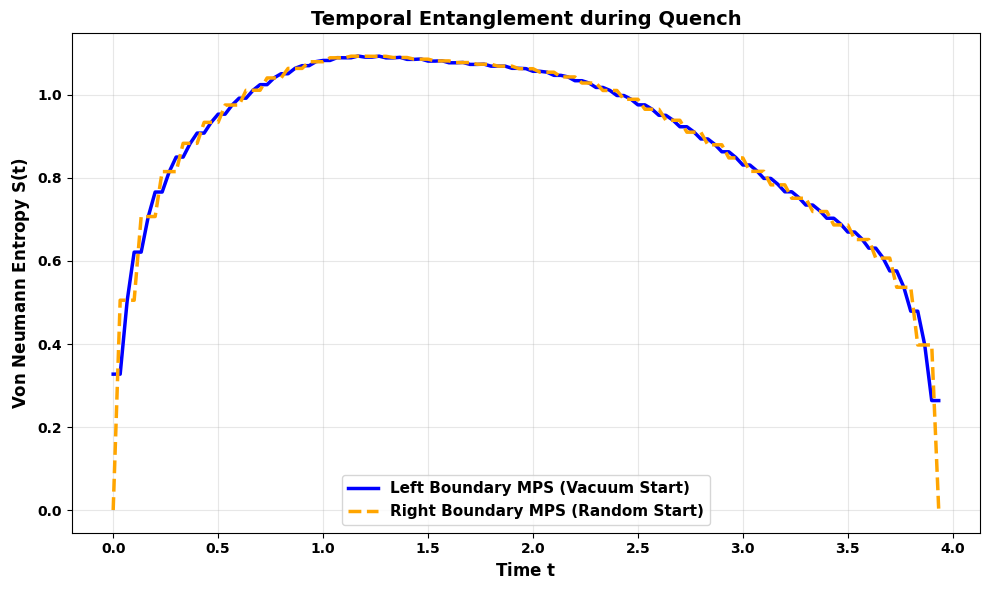

In [57]:
# We compute the Left & Right Entropy Profiles using the corresponding method from the MPS class
S_profile_L = L.entropy_profile()
S_profile_R = R.entropy_profile()

# Time Axis
bond_indices = np.arange(len(S_profile_L))
time_axis = bond_indices * (dt / 3.0)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(time_axis, S_profile_L, label='Left Boundary MPS (Vacuum Start)', color='blue', lw=2.5)
plt.plot(time_axis, S_profile_R, label='Right Boundary MPS (Random Start)', color='orange', ls='--', lw=2.5)

plt.xlabel('Time $t$', fontsize=12)
plt.ylabel(r'Von Neumann Entropy $S(t)$', fontsize=12)
plt.title(f'Temporal Entanglement during Quench', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

The plot above reveals some critical insights into the physics of the system and the validity of our Transverse Tensor Network approach:

* We can observe that there exists a perfect overlap between the Left Boundary MPS (initialized as a Vacuum state) and the Right Boundary MPS (initialized as a Random state), confirming that the Boundary Independence hypothesis is confirmed along the whole time evolution.

* The entanglement entropy $S(t)$ vanishes at the begining and at the end of the time evolution, forming an "arch":
    * At $t=0$: The system is initialized in a product state $|\psi_0\rangle = |\uparrow\uparrow\dots\rangle$, which has zero entanglement.
    * At $t=T$: The tensor network is closed by a Trace operation (projecting onto $\sum |u\rangle\langle u|$). This is effectively a "product state" boundary condition in the future, forcing the correlations to vanish as the vertical MPS approaches the end of the simulation window.


---

## **Bonus Point:** Scaling Analysis

The final question asks us to investigate how the maximum entanglement entropy of the boundary MPS scales as we increase the total simulation time $T$. 

In order to quantify this "complexity growth with time", we repeat (in a loop) the transverse contraction procedure described in Part II for a range of total (final) times $T \in [0.5, \dots, 4.0]$ while tracking the maximum entanglement entropy ($S_{max}$). We do this only for the right contraction $|R\rangle$, as specified in the assignment instructions.

For the final plot, we have compared our Simulation points against a linear fit for clarity (see discussion below).

In [56]:
# Define the range of Final Times to simulate (from T=0.5 to T=4.0 in 0.5 steps)
T_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
max_entropies = []

# Simulation parameters
dt = 0.1
N = 50
central_site = N // 2
tol = 1e-5
max_bond = 200
g = 0.7

# Pre-compute Trotter gates
gates = get_trotter_gates(g, dt)

# We repeat the same process as in Part II but for different final times T
for T in tqdm(T_values, desc="Simulating for different final T"):
    
    steps = int(T / dt)
    vertical_len = 3 * steps
    
    # We initialize Right Boundary MPS as a vacuum state
    R = MPS.init_vertical_boundary(vertical_len, d_phys=1, state_type='vacuum')
    
    entropies_history = []
    
    # Right Sweep
    for k in range(N - 1, central_site, -1):
        
        # Build Transfer Matrix (MPO) E for this spatial site (column)
        E_k = build_transfer_matrix(k, N, steps, gates)
        
        # Transpose for Right-to-Left
        E_swapped = [W.transpose(1, 0, 2, 3) for W in E_k]
        
        # Apply + Compress + Renormalize
        R = R.apply_mpo(E_swapped)
        R.compress(max_bond)
        R.A[0] /= R.norm_canonical()
        
        # Check Convergence
        S_center = R.entropy_at_center()
        entropies_history.append(S_center)
        
        # Stop once convergence for this T is reached
        if len(entropies_history) > 6 and abs(S_center - entropies_history[-3]) < tol:
            break
    
    # We measure the maximum entropy value from the profile of the converged state
    profile = R.entropy_profile()
    max_S = np.max(profile)
    max_entropies.append(max_S)

Simulating for different final T:   0%|          | 0/8 [00:00<?, ?it/s]

Simulating for different final T: 100%|██████████| 8/8 [1:35:22<00:00, 715.31s/it] 


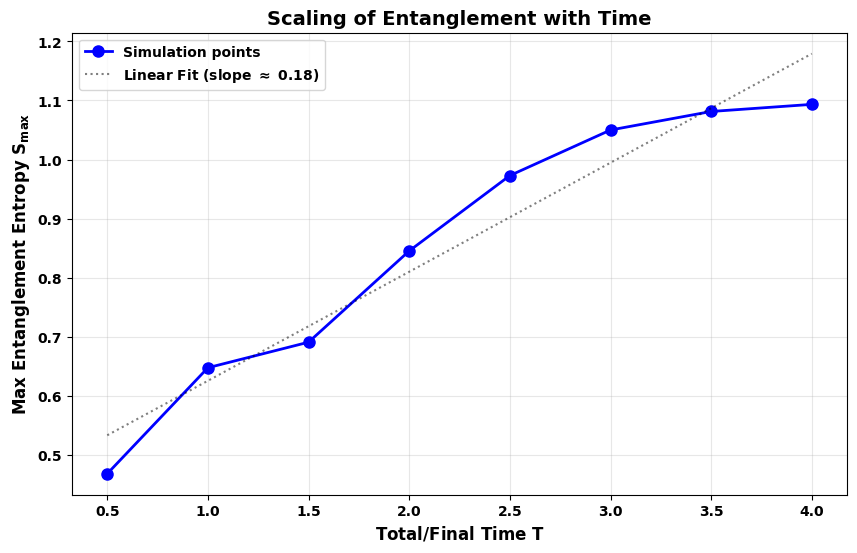

In [59]:
# PLOTTING

plt.figure(figsize=(10, 6))
plt.plot(T_values, max_entropies, 'o-', label='Simulation points', color='blue', lw=2, markersize=8)

# Linear fit to our data
z = np.polyfit(T_values, max_entropies, 1)
p = np.poly1d(z)
plt.plot(T_values, p(T_values), 'k:', alpha=0.5, label=f'Linear Fit (slope $\\approx$ {z[0]:.2f})')

plt.xlabel('Total/Final Time $T$', fontsize=12)
plt.ylabel(r'Max Entanglement Entropy $S_{max}$', fontsize=12)
plt.title('Scaling of Entanglement with Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

From the plot, we observe a clear linear relationship: 
$$S_{max}(T) \approx \alpha T + \text{const},$$
with a slope $\alpha \approx 0.18$.

In the transverse TN picture (rotated with respecto to the standard one), the "system size" of the vertical MPS is determined by the total time $T$ (height of the MPO column). Since $S \propto \text{Size}$, our time-evolution operator obeys the so-called **Volume Law** for entanglement. 

This confirms that the computational resources (bond dimension) required to simulate the system grow exponentially with time. This linear growth of entropy acts as a "barrier", limiting the accessible time scales for classical Tensor Network algorithms.